In [2]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
Saving validation.csv to validation (1).csv


<ipython-input-35-a2de7555f741>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='toxic', palette='Blues')


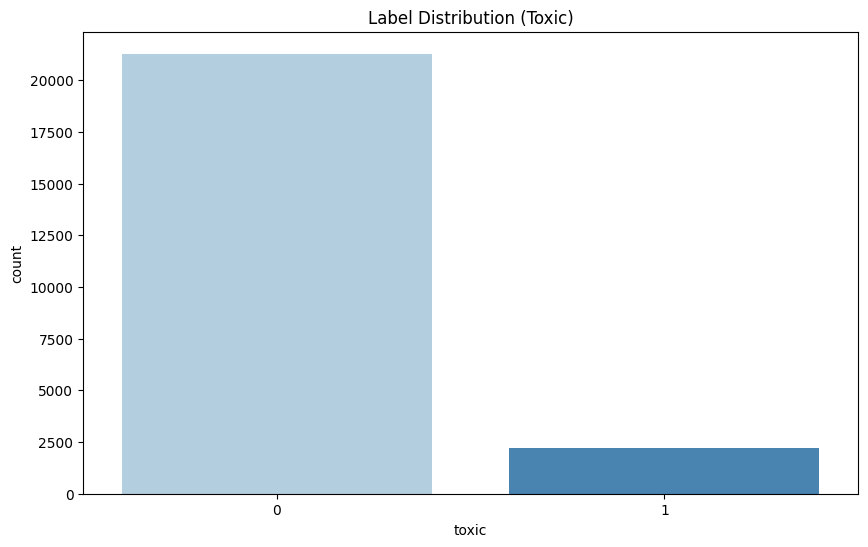

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSVs
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('validation.csv')  # Add your validation CSV here

# Preview train data
print("Train Data:")
print(train.head())
print(train.info())
print(train.isnull().sum())

# Preview test data
print("\nTest Data:")
print(test.head())
print(test.info())
print(test.isnull().sum())

# Preview validation data
print("\nValidation Data:")
print(val.head())
print(val.info())
print(val.isnull().sum())


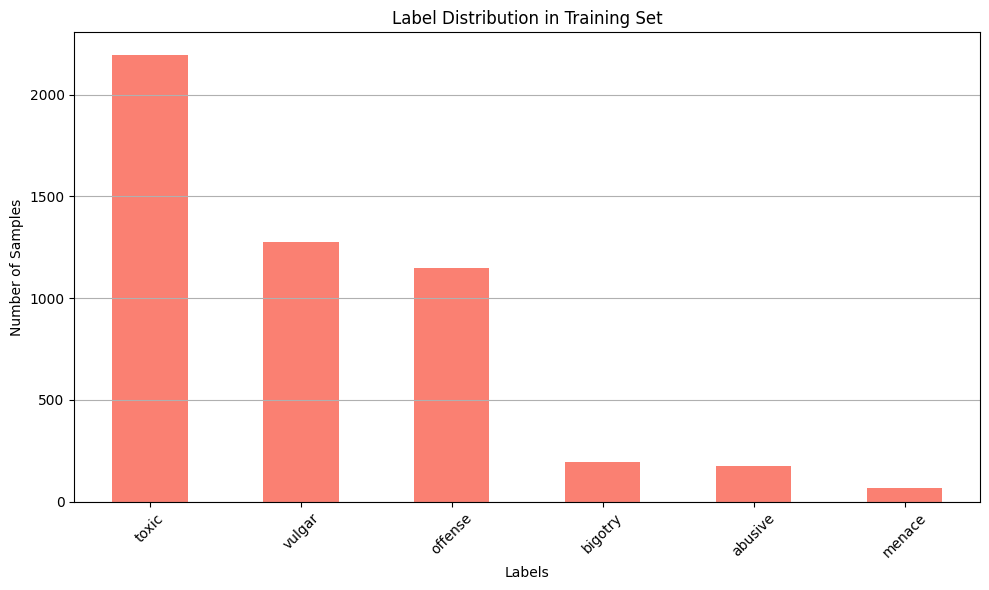

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check label distribution
labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

# Plot label distributions
plt.figure(figsize=(10, 6))
train[labels].sum().sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('Label Distribution in Training Set')
plt.ylabel('Number of Samples')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [25]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing with column checks
train['clean_text'] = train['feedback_text'].apply(preprocess_text)

# For test set
if 'feedback_text' in test.columns:
    test['clean_text'] = test['feedback_text'].apply(preprocess_text)
elif 'content' in test.columns:
    test['clean_text'] = test['content'].apply(preprocess_text)

# For validation set
if 'feedback_text' in val.columns:
    val['clean_text'] = val['feedback_text'].apply(preprocess_text)
elif 'content' in val.columns:
    val['clean_text'] = val['content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit on training data and transform train, validation, and test
X_train = vectorizer.fit_transform(train['clean_text'])
X_val = vectorizer.transform(val['clean_text'])
X_test = vectorizer.transform(test['clean_text'])  # No labels here, just for final prediction


In [31]:
print(val.columns)


Index(['id', 'feedback_text', 'lang', 'toxic', 'clean_text'], dtype='object')


In [32]:
# Use only the available label in validation set
labels = ['toxic']  # Just 'toxic' since it's the only label in val

# Create label datasets
y_train = train[labels]
y_val = val[labels]


In [33]:
from sklearn.linear_model import LogisticRegression

# Initialize and train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train.values.ravel())  # .ravel() flattens the target array

# Predict on validation set
y_val_pred = lr_model.predict(X_val)


Classification Report:

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       706
           1       0.00      0.00      0.00       134

    accuracy                           0.84       840
   macro avg       0.42      0.50      0.46       840
weighted avg       0.71      0.84      0.77       840

Accuracy: 0.8392857142857143


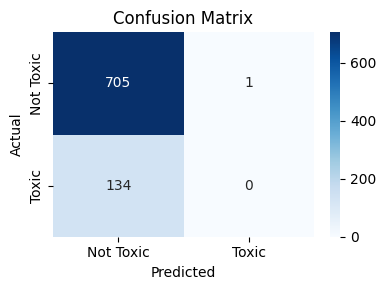

ROC-AUC Score: 0.5985106337998393


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC-AUC Score
try:
    y_val_proba = lr_model.predict_proba(X_val)[:, 1]
    print("ROC-AUC Score:", roc_auc_score(y_val, y_val_proba))
except:
    print("ROC-AUC Score could not be computed.")


<ipython-input-36-a2de7555f741>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='toxic', palette='Blues')


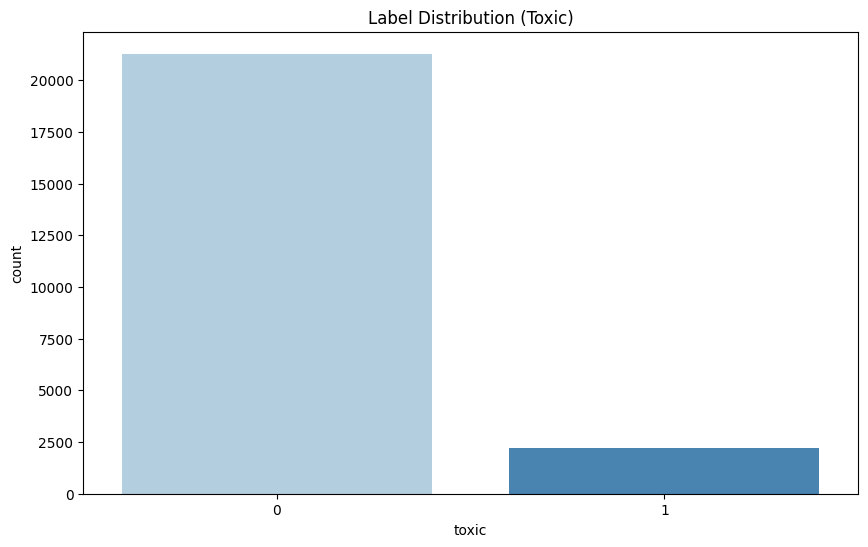

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Label distribution in the training set
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='toxic', palette='Blues')
plt.title('Label Distribution (Toxic)')
plt.show()


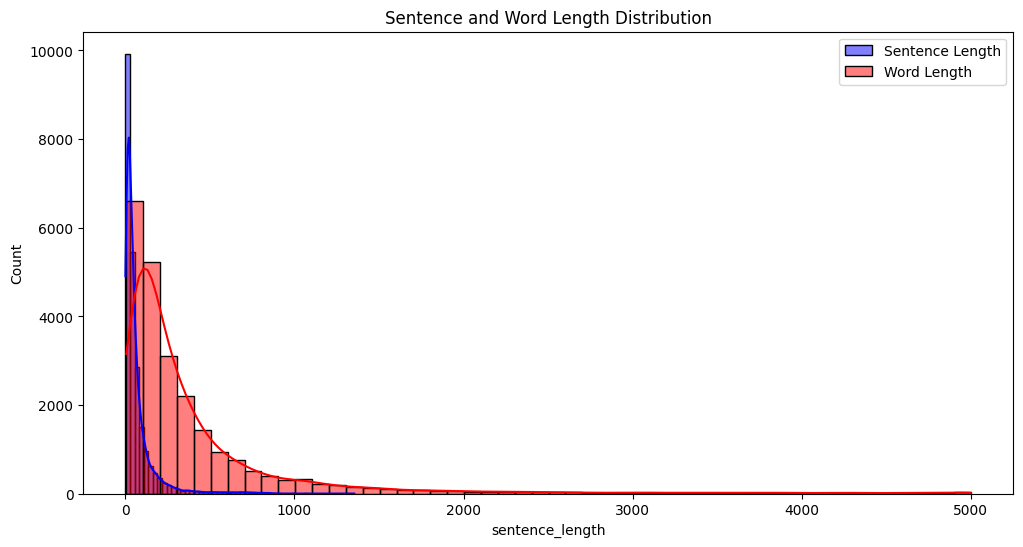

In [37]:
# Word and sentence lengths
train['sentence_length'] = train['feedback_text'].apply(lambda x: len(x.split()))
train['word_length'] = train['feedback_text'].apply(lambda x: len(x))

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(train['sentence_length'], kde=True, bins=50, color='blue', label='Sentence Length')
sns.histplot(train['word_length'], kde=True, bins=50, color='red', label='Word Length')
plt.legend()
plt.title('Sentence and Word Length Distribution')
plt.show()
